In [55]:
import os
import copy
import json
import time
#import pandas as pd
#import collections
import networkx as nx
import matplotlib.pyplot as plt
#from itertools import combinations, permutations
from itertools import product

%matplotlib inline  

In [56]:
class BaseGraph:
    def __init__(self, inputs):
        self.inputs = inputs
        self.shaft_name = None
        self.edge_list = None
        self.start_list = None
        self.end_list = None
        self.graph = nx.Graph() #nx.DiGraph()
    
    def create_edge_list(self):
        # create list of edges
        elist = []
        for i, val in enumerate(self.inputs['Edges']):
            e1 = val['Node1']
            e2 = val['Node2']
            elist.append((e1, e2, ))
            
        self.edge_list = elist
        
    def create_node_list(self):
        # Create list of starting and ending nodes
        start_list = []
        end_list = []
        for i, val in enumerate(self.inputs['Nodes']):
            if val['NodeType'] == 'Shaft':
                start_list.append(val['Id'])
                self.shaft_name = val['Name']
            if val['NodeType'] == 'Vav':
                end_list.append(val['Id'])
                
        self.start_list = start_list
        self.end_list = end_list
        
    def add_edges_to_graph(self):
        self.graph.add_edges_from(self.edge_list)
        
    def set_node_demand(self, number, attribute, demand):
        self.graph.node[number][attribute] = demand
        
    def set_edge_attribute(self, n1, n2, attribute, value):
        #self.graph.edge[number][attribute] = value
        #nx.set_edge_attributes(self.graph, attribute, value)
        self.graph.edge[n1][n2][attribute] = value
        
    def set_lengths(self):
        # Create list of nodes and airflow
        edges = [x for x in self.inputs['Edges']]
        for edge in edges:
            self.set_edge_attribute(edge['Node1'], edge['Node2'], 'length', edge['Distance'])
        
    def set_airflows(self):
        # Add airflow to node data
        vav_nodes = [x for x in self.inputs['Nodes'] if x['NodeType'] == 'Vav']
        for x in vav_nodes:
            for y in self.inputs['Spaces']:
                if y['UniqueId'] == x['SpaceId']:
                    self.set_node_demand(x['Id'], 'demand', y['Airflow'])
        
    def print_graph(self):
        nx.draw(self.graph, with_labels=True, font_weight='bold')
        

In [57]:
class RouteOptions:
    def __init__(self, base_graph, shaft_name, source, targets):
        self.base_graph = base_graph
        self.shaft_name = shaft_name
        self.source = source
        self.targets = targets
        self.individual_paths = None
        self.path_combinations = None
        self.graphs = None
        self.pressure_drops = []
        
    def create_all_paths_to_each_target(self):
        paths = {}
        for target in self.targets:
            target_key = str(target)
            paths.update({target_key: []})
            for path in nx.all_simple_paths(self.base_graph, source=self.source, target=target):
                paths[target_key].append({"source": self.source, "target": target, "path": path})
                
        self.individual_paths = paths
        
    def create_all_path_combinations(self):
        # Create list of combinations of paths
        path_combinations = []
        for target in self.individual_paths:
            path_combinations.append(list(range(0, len(self.individual_paths[target]))))

        self.path_combinations = list(product(*path_combinations))
    
    def create_graph_options(self):
        # Create new graphs for each combination
        final_graphs = []

        # Loop for each path combination
        for path_combination in self.path_combinations:
            new_graph =nx.Graph() # nx.DiGraph()

            # Loop for each target
            for target_number, target in enumerate(self.targets):
                edge_list = []

                my_path = self.individual_paths[str(target)][path_combination[target_number]]['path']

                # Loop for each node in path
                for i in range(0, len(my_path)-1):
                    edge_list.append((my_path[i], my_path[i+1]))

                G1 = nx.Graph() #nx.DiGraph()
                G1.add_edges_from(edge_list)

                if target_number > 0:
                    new_graph = nx.compose(G1, new_graph)
                else:
                    new_graph = G1

            final_graphs.append(new_graph)

        self.graphs = final_graphs
        
        print('number of graphs: ' + str(len(self.graphs)))

    def set_edge_attribute(self, graph_number, n1, n2, attribute, value):
        print(self.graphs)
        print(graph_number)
        
        all_edges = self.graphs[graph_number].edges()
        if (n1, n2) in all_edges or (n2, n1) in all_edges:
            self.graphs[graph_number].edge[n1][n2][attribute] = value
        
    def set_lengths(self, inputs):
        # Set lenths to edge attributes
        for i, graph in enumerate(self.graphs):
            for edge in inputs:
                self.set_edge_attribute(i, edge[0], edge[1], 'length', edge[2]['length'])
        
    def set_node_demand(self, graph_number, node_number, attribute, demand):
        self.graphs[graph_number].node[node_number][attribute] = demand
        
    def set_terminal_airflows(self, inputs):
        # Set airflow to node attributes
        for i, graph in enumerate(self.graphs):
            for node in inputs:
                if node[1]:
                    self.set_node_demand(i, node[0], 'demand', node[1]['demand'])
                    
    def calculate_airflows(self):
        for i, graph in enumerate(self.graphs):
            for target in self.targets:
                path = nx.shortest_path(graph, source=self.source, target=target)
                path.remove(target)
                
                for node in path:
                    if graph.node[target]:
                        terminal_demand = graph.node[target]['demand']
                    else:
                        terminal_demand = 0
                        
                    if graph.node[node]:
                        existing_demand = graph.node[node]['demand']
                    else:
                        existing_demand = 0
                        
                    new_demand = existing_demand + terminal_demand
                    self.set_node_demand(i, node, 'demand', new_demand)
    
    def calculate_static_pressure_drop(self):
        ## TODO THIS needs to be calculated for each duct runs to find the maximum value

        for i, graph in enumerate(self.graphs):
            total_pressure_drop = 0.0
            for target in self.targets:
                path = nx.shortest_path(graph, source=self.source, target=target)
                path_pressure_drop = 0.0
                
                # Loop for each node in path
                for j in range(0, len(path)-1):
                    # Check if nodes are in edge
                    if (path[j], path[j+1]) in graph.edges():
                        n1 = path[j]
                        n2 = path[j+1]
                    elif (path[j+1], path[j]) in graph.edges():
                        n1 = path[j+1]
                        n2 = path[j]
                    
                    edge = graph.edges((n1, n2))
                    length = graph.edge[n1][n2]['length'] # get the length [ft]
                    friction_loss = 0.2 
                    pressure_drop = friction_loss * length/100.0  # calculate the pressure drop [in wg]
                    self.set_edge_attribute(i, n1, n2, 'pressure_drop', pressure_drop)
                    
                    path_pressure_drop += pressure_drop
                    
                #Compare path to total pressure drop
                total_pressure_drop = max(total_pressure_drop, path_pressure_drop)
            
            # Set the system pressure drop
            self.pressure_drops.append(total_pressure_drop)
                     
    def convert_to_direct(self):
        for i, graph in enumerate(self.graphs):
            self.graphs[i].to_directed()
            
    def remove_closed_solutions(self):
        # Find and remove closed loop solutions

        # Loop for all graphs
        G = self.base_graph
        DG = nx.DiGraph(G)
        simple_cycles = list(nx.simple_cycles(DG))
        simple_cycles = [x for x in simple_cycles if len(x) > 2]

        for closed_loop in simple_cycles:
            # Loop for each node in path
            closed_loop_list = []
            closed_loop = simple_cycles[0]
            for i in range(0, len(closed_loop)-1):
                closed_loop_list.append((closed_loop[i], closed_loop[i+1]))
            closed_loop_list.insert(0, (0, 1))    

            # Remove graph if it matches cycle
            for i, final_graph in enumerate(self.graphs):
                #print(my_closed_loop)
                if self.graphs[i].edges() == closed_loop_list:
                    self.graphs.remove(final_graph)
    
    def print_graph_options(self):
        fig = plt.figure(figsize=(10, 5*(len(self.graphs))))
        for i, F in enumerate(self.graphs):
            ax = fig.add_subplot(len(self.graphs),1,i+1)
            nx.draw(F, with_labels=True, font_weight='bold')

        plt.show()

In [58]:
#t_start = time.time()

In [59]:
#filename = 'Arch Model 3.json'
filename = 'Arch Model4.json'

In [60]:
with open(os.path.join('..', 'models', filename)) as json_data:
    inputs = json.load(json_data)

In [61]:
# Run calclations to create base mesh
base_graph = BaseGraph(inputs)
base_graph.create_edge_list()
base_graph.create_node_list()
base_graph.add_edges_to_graph()
base_graph.set_airflows()
base_graph.set_lengths()
#base_graph.print_graph()

#base_graph.graph.nodes(data=True)
#base_graph.graph.edges(data=True)

11
number of graphs: 32
[<networkx.classes.graph.Graph object at 0x000001525763B5C0>, <networkx.classes.graph.Graph object at 0x000001525763B668>, <networkx.classes.graph.Graph object at 0x000001525763B198>, <networkx.classes.graph.Graph object at 0x00000152576358D0>, <networkx.classes.graph.Graph object at 0x00000152524E5940>, <networkx.classes.graph.Graph object at 0x0000015256765A20>, <networkx.classes.graph.Graph object at 0x000001525762FEB8>, <networkx.classes.graph.Graph object at 0x000001525762FA58>, <networkx.classes.graph.Graph object at 0x000001525762F940>, <networkx.classes.graph.Graph object at 0x000001525762FF98>, <networkx.classes.graph.Graph object at 0x000001525762F6D8>, <networkx.classes.graph.Graph object at 0x000001525762F2B0>, <networkx.classes.graph.Graph object at 0x000001525762F588>, <networkx.classes.graph.Graph object at 0x000001525762F860>, <networkx.classes.graph.Graph object at 0x000001525762F4E0>, <networkx.classes.graph.Graph object at 0x000001525762F9B0>,

C:\Users\jmcneill\AppData\Local\Continuum\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\jmcneill\AppData\Local\Continuum\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\jmcneill\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\jmcneill\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: 

[<networkx.classes.graph.Graph object at 0x000001525763B5C0>, <networkx.classes.graph.Graph object at 0x000001525763B668>, <networkx.classes.graph.Graph object at 0x000001525763B198>, <networkx.classes.graph.Graph object at 0x00000152576358D0>, <networkx.classes.graph.Graph object at 0x00000152524E5940>, <networkx.classes.graph.Graph object at 0x0000015256765A20>, <networkx.classes.graph.Graph object at 0x000001525762FEB8>, <networkx.classes.graph.Graph object at 0x000001525762FA58>, <networkx.classes.graph.Graph object at 0x000001525762F940>, <networkx.classes.graph.Graph object at 0x000001525762FF98>, <networkx.classes.graph.Graph object at 0x000001525762F6D8>, <networkx.classes.graph.Graph object at 0x000001525762F2B0>, <networkx.classes.graph.Graph object at 0x000001525762F588>, <networkx.classes.graph.Graph object at 0x000001525762F860>, <networkx.classes.graph.Graph object at 0x000001525762F4E0>, <networkx.classes.graph.Graph object at 0x000001525762F9B0>, <networkx.classes.graph

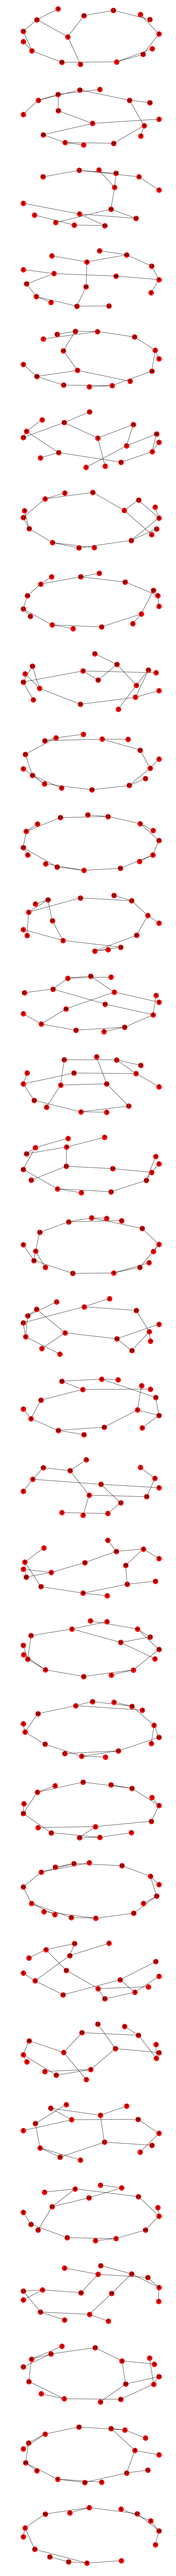

In [62]:
# Run calculations to create options
route_option_list = []
# Loop for each shaft option

for start_node in base_graph.start_list:
    print(start_node)
    route_options = RouteOptions(base_graph.graph, base_graph.shaft_name, start_node, base_graph.end_list)
    route_options.create_all_paths_to_each_target()
    route_options.create_all_path_combinations()
    route_options.create_graph_options()
    route_options.remove_closed_solutions()
    #route_options.convert_to_direct()
    route_options.set_lengths(base_graph.graph.edges(data=True))
    route_options.set_terminal_airflows(base_graph.graph.nodes(data=True))
    route_options.calculate_airflows()
    route_options.calculate_static_pressure_drop()
    #route_options.print_graph_options()
    
    route_option_list.append({'start_node': start_node, 'graphs': route_options})

In [63]:
data = {}
solutions = []

#SHEET_METAL = 5.0
#SHAFT = "Shaft-969767"
#COST = 15.0
#STATIC_PRESSURE = 2.0

#friction_loss = 0.2 # in wg / 100 ft
velocity = 2000 # fpm
density = 1.1 # lb/ft2 of sheet metal
sheet_metal_unit_cost = 6.0 # USD/lb

data["Nodes"] = inputs["Nodes"]
#n = 1

# Loop for shafts
for route_option in route_option_list:
    # TODO LOOP FOR SHAFT LOCATIIONS
    final_graphs = route_option['graphs'].graphs
    shaft =  route_option['graphs'].shaft_name

    for i, solution in enumerate(final_graphs):
        edges = []
        total_weight = 0.0
        total_cost = 0.0

        pressure_drop = route_option_list[0]['graphs'].pressure_drops[i]

        for n1,n2 in solution.edges():
            if solution.node[n2]:
                airflow = solution.node[n2]['demand']
            else:
                airflow = 0

            cross_sectional_area = airflow/velocity  # ft2
            diameter = max(round(2.0*(cross_sectional_area/3.14)**0.5*12.0, 1), 5.0)/12.0
            cross_sectional_area = 3.14*(diameter/2)**2.0 # recalculate area

            if solution.edge[n1][n2]:
                length = solution.edge[n1][n2]['length'];
            else:
                length = 0

            weight = cross_sectional_area*length*density # Sheet metal weight in lb
            total_weight += weight

            cost = sheet_metal_unit_cost*weight # Sheet metal cost
            total_cost += cost      

            edges.append({"Node1":n1, "Node2": n2, "Distance": length, "Diameter": diameter, "Airflow": airflow})

        solutions.append({"Id":i, "Shaft": shaft, "SheetMetal": total_weight, "Cost": total_cost, "StaticPressure": pressure_drop, "Edges":edges})

        data["Solutions"] = solutions

with open(os.path.join('..', 'models', 'solutions_' + filename), 'w') as outfile:  
    json.dump(data, outfile)

In [64]:

"""
# Find and remove closed loop solutions

# Determine closed loops
G = final_graphs[0]
DG = nx.DiGraph(G)
simple_cycles = list(nx.simple_cycles(DG))
simple_cycles = [x for x in simple_cycles if len(x) > 2]

for closed_loop in simple_cycles:
    # Loop for each node in path
    closed_loop_list = []
    closed_loop = simple_cycles[0]
    for i in range(0, len(closed_loop)-1):
        closed_loop_list.append((closed_loop[i], closed_loop[i+1]))
    closed_loop_list.insert(0, (0, 1))    

    # Remove graph if it matches cycle
    for i, final_graph in enumerate(final_graphs):
        #print(my_closed_loop)
        if final_graphs[i].edges() == closed_loop_list:
            final_graphs.remove(final_graph)
"""

'\n# Find and remove closed loop solutions\n\n# Determine closed loops\nG = final_graphs[0]\nDG = nx.DiGraph(G)\nsimple_cycles = list(nx.simple_cycles(DG))\nsimple_cycles = [x for x in simple_cycles if len(x) > 2]\n\nfor closed_loop in simple_cycles:\n    # Loop for each node in path\n    closed_loop_list = []\n    closed_loop = simple_cycles[0]\n    for i in range(0, len(closed_loop)-1):\n        closed_loop_list.append((closed_loop[i], closed_loop[i+1]))\n    closed_loop_list.insert(0, (0, 1))    \n\n    # Remove graph if it matches cycle\n    for i, final_graph in enumerate(final_graphs):\n        #print(my_closed_loop)\n        if final_graphs[i].edges() == closed_loop_list:\n            final_graphs.remove(final_graph)\n'